# Сегментация камней

### Разархивация всех данных

### Импорт всех необходимых библиотек

In [1]:
from pycocotools.coco import COCO
import cv2
import os
import json
import numpy as np
import multiprocessing
from fastai.vision.all import *
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
start_dir = "/storage/vskovoroda/Stones/data/"
os.chdir(start_dir)

In [4]:
os.listdir()

['part3',
 'part5',
 'part4',
 'part2',
 'annotations',
 'models',
 'images',
 'part1']

## Создаине DataBlock для обучения моделей

In [5]:
def get_msk(o):
    img = cv2.imread(str(data_path/'annotations'/o.name))
    img[img>0] = 1
    return img

In [6]:
codes = ['no_asbest', 'asbest']
data_path = Path('/storage/vskovoroda/Stones/data')
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items=get_image_files,
                splitter=RandomSplitter(),
                get_y=get_msk,
                batch_tfms=[Normalize.from_stats(*imagenet_stats), aug_transforms]
               )
dls = binary.dataloaders(data_path/'images', bs=3)

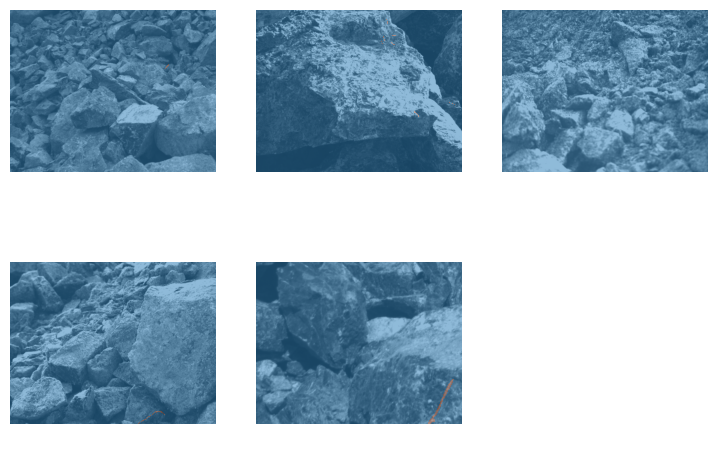

In [8]:
dls.show_batch(max_n=8)

In [8]:
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [16]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [ ]:
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.005253,0.004294,07:42
1,0.004224,0.004294,07:42


In [ ]:
learn.save('Unet')

Path('models/Unett.pth')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [9]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [10]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [11]:
learn.fit(20)

epoch,train_loss,valid_loss,time
0,0.002195,0.002470,16:00
1,0.001996,0.002470,15:59
2,0.002471,0.002470,15:58
3,0.002653,0.002470,15:59
4,0.001267,0.002470,15:59
5,0.003587,0.002470,16:00
6,0.003616,0.002470,16:00
7,0.003756,0.002470,15:59
8,0.002523,0.002470,15:59
9,0.002571,0.002470,15:59


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [25]:
learn.save('UnetPlusPlus')

Path('models/UnetPlusPlus.pth')

In [13]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [7]:
model = smp.MAnet(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [8]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [9]:
learn.fit(7)

epoch,train_loss,valid_loss,time
0,0.007864,0.008418,08:56
1,0.006587,0.008418,08:55
2,0.007289,0.008418,08:55
3,0.005713,0.008418,08:55


KeyboardInterrupt: 

In [10]:
learn.save('MAnet')

Path('models/MAnet.pth')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
model = smp.Linknet(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [ ]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [ ]:
learn.fit(20)

In [ ]:
learn.save('Linknet')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
#########################################

In [24]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,time
0,0.002813,0.002470,15:59


epoch,train_loss,valid_loss,time
0,0.002545,0.002470,16:00
1,0.002240,0.002470,15:59


In [ ]:
smp.Unet
smp.UnetPlusPlus
smp.MAnet
smp.Linknet
smp.PSPNet
smp.FPN
smp.PAN
smp.DeepLabV3
smp.DeepLabV3Plus

In [10]:
learn.fit(10)

epoch,train_loss,valid_loss,time
0,7.390676,0.671788,00:22
1,3.031313,0.646121,00:20
2,1.739566,0.640595,00:19
3,1.180953,0.580568,00:19
4,0.895410,0.518434,00:19
5,0.745128,0.538023,00:19
6,0.659185,0.576371,00:19
7,0.603883,0.521982,00:19
8,0.567518,0.561850,00:20
9,0.540553,0.491454,00:20


In [20]:
interp = SegmentationInterpretation.from_learner(learn)

In [23]:
interp.plot_top_losses(k=2)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

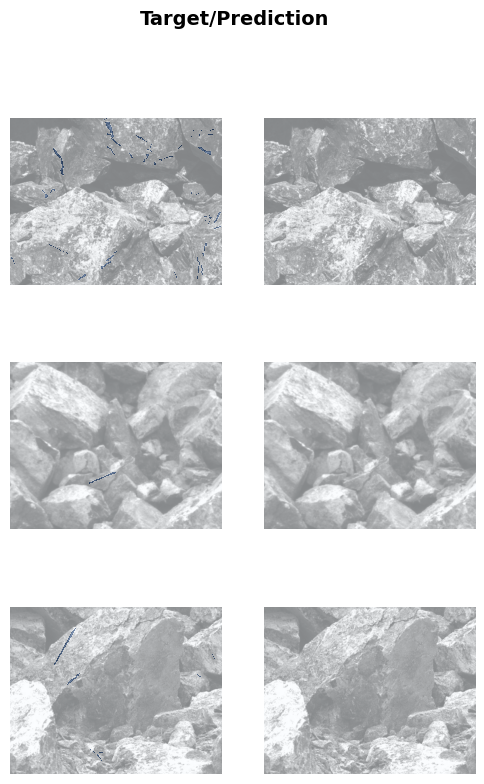

In [11]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [14]:
learn.load('40blur_7')

In [17]:
path = Path('data')
dls = SegmentationDataLoaders.from_label_func(path = path,
            item_tfms=Resize(600),
            bs = 5,
            batch_tfms=[Normalize.from_stats(*imagenet_stats), aug_transforms],
            fnames = get_image_files(path/'images'),
            label_func = lambda o: get_msk(o), codes = ['no_stone', 'stone'])

In [18]:
learn.dls = dls

In [18]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [22]:
imges_names = (path/'images').ls()
masks_names = (path/'SegmentationClass').ls()

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

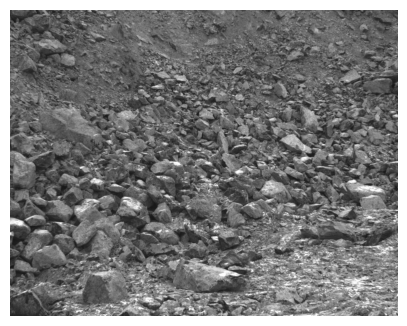

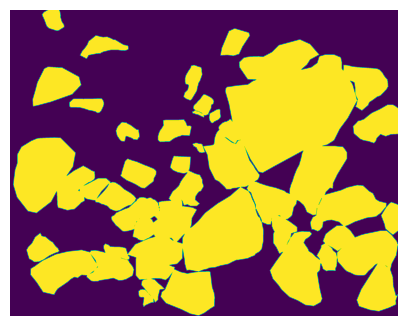

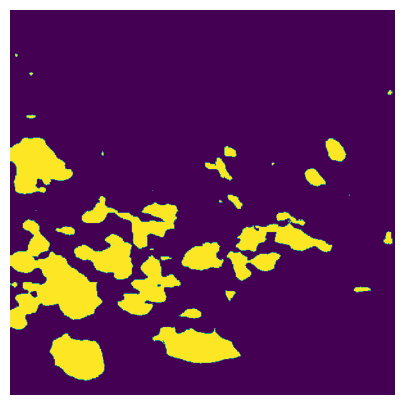

In [23]:
k = 2
img = PILImage.create(imges_names[k])
msk = PILMask.create(masks_names[k])
pred = learn.predict(PILImage.create(imges_names[k]))
show_image(img), show_image(msk), show_image(pred[0])